In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

 ### preprocessing donnée communes

In [3]:
from pathlib import Path

fp = Path("data") / "raw" / "communes" / "ADE_4-0_GPKG_WGS84G_FRA-ED2025-11-20.gpkg"
if not fp.exists():
	raise FileNotFoundError(f"File not found: {fp.resolve()}")
communes = gpd.read_file(fp, layer='commune')

In [4]:
communes

,cleabs,nom_officiel,nom_officiel_en_majuscules,statut,code_insee,population,date_du_recensement,organisme_recenseur,code_insee_du_canton,code_insee_de_l_arrondissement,code_insee_du_departement,code_insee_de_la_region,codes_siren_des_epci,code_siren,code_postal,superficie_cadastrale,geometry
0,COMMUNE_0000000000001001,L'Abergement-Clémenciat,L'ABERGEMENT-CLEMENCIAT,Commune simple,01001,859,2022-01-01,INSEE,0108,012,01,84,200069193,210100012,01400,1590,"MULTIPOLYGON (((4.95841 46.15327, 4.95812 46.1..."
1,COMMUNE_0000000000001002,L'Abergement-de-Varey,L'ABERGEMENT-DE-VAREY,Commune simple,01002,273,2022-01-01,INSEE,0101,011,01,84,240100883,210100020,01640,920,"MULTIPOLYGON (((5.4302 45.98277, 5.43012 45.98..."
2,COMMUNE_0000000000001004,Ambérieu-en-Bugey,AMBERIEU-EN-BUGEY,Commune simple,01004,15554,2022-01-01,INSEE,0101,011,01,84,240100883,210100046,01500,2460,"MULTIPOLYGON (((5.40882 45.94206, 5.4085 45.94..."
3,COMMUNE_0000000000001005,Ambérieux-en-Dombes,AMBERIEUX-EN-DOMBES,Commune simple,01005,1917,2022-01-01,INSEE,0122,012,01,84,200042497,210100053,01330,1590,"MULTIPOLYGON (((4.94298 45.97962, 4.94257 45.9..."
4,COMMUNE_0000000000001006,Ambléon,AMBLEON,Commune simple,01006,114,2022-01-01,INSEE,0104,011,01,84,200040350,210100061,01300,590,"MULTIPOLYGON (((5.57083 45.75338, 5.57219 45.7..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34872,COMMUNE_0000000000097611,Mamoudzou,MAMOUDZOU,Préfecture de région,97611,71437,2017-01-01,INSEE,97699,NR,976,06,200060457,200008837,PLURI,4230,"MULTIPOLYGON (((45.23784 -12.81009, 45.23791 -..."
34873,COMMUNE_0000000000097614,Ouangani,OUANGANI,Commune simple,97614,10203,2017-01-01,INSEE,97610,NR,976,06,200059871,200008852,97670,1850,"MULTIPOLYGON (((45.15409 -12.87424, 45.14544 -..."
34874,COMMUNE_0000000000097607,Dembeni,DEMBENI,Commune simple,97607,15848,2017-01-01,INSEE,97603,NR,976,06,200060457,200008787,97660,3838,"MULTIPOLYGON (((45.16269 -12.87999, 45.15888 -..."
34875,COMMUNE_0000000000097613,M'Tsangamouji,M'TSANGAMOUJI,Commune simple,97613,6432,2017-01-01,INSEE,97613,NR,976,06,200059871,200008829,97650,2204,"MULTIPOLYGON (((45.06646 -12.75976, 45.06631 -..."


In [5]:
# Liste des codes INSEE des départements d'outre-mer
outre_mer_codes = ['971', '972', '973', '974', '976']

# Filtrer les communes pour exclure celles ayant un code INSEE d'outre-mer
communes = communes[~communes['code_insee_du_departement'].isin(outre_mer_codes)]

In [6]:
from pathlib import Path

# Define file paths
csv_file_path = "data/raw/datagouv/QUOT_SIM2_previous-2020-202510.csv"
parquet_file_path = "data/intermediate/datagouv/QUOT_SIM2_previous-2020-202510.parquet"

# Check if the Parquet file already exists
if not Path(parquet_file_path).exists():
    # Load the CSV file into a DataFrame
    datagouv = pd.read_csv(csv_file_path, sep=';')

    # Save the DataFrame as a Parquet file
    datagouv.to_parquet(parquet_file_path, engine='pyarrow', index=False)

    print(f"CSV file has been transformed into a Parquet file at {parquet_file_path}")
else:
    print(f"Parquet file already exists at {parquet_file_path}")

Parquet file already exists at data/intermediate/datagouv/QUOT_SIM2_previous-2020-202510.parquet


In [7]:
datagouv=pd.read_parquet("data/intermediate/datagouv/QUOT_SIM2_previous-2020-202510.parquet", engine='pyarrow')


In [12]:
display(datagouv)

,LAMBX,LAMBY,DATE,PRENEI,PRELIQ,T,FF,Q,DLI,SSI,...,RESR_NEIGE6,HTEURNEIGE,HTEURNEIGE6,HTEURNEIGEX,SNOW_FRAC,ECOULEMENT,WG_RACINE,WGI_RACINE,TINF_H,TSUP_H
0,600,24010,20200101,0.0,0.4,9.9,2.1,7.414,3161.6,111.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.315,0.0,9.5,10.9
1,600,24010,20200102,0.0,0.6,11.3,5.5,7.396,2955.5,55.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.314,0.0,9.5,11.9
2,600,24010,20200103,0.0,0.8,9.6,6.1,6.458,3066.2,56.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.313,0.0,8.8,10.6
3,600,24010,20200104,0.0,0.0,8.1,2.7,5.230,2564.4,142.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.312,0.0,5.4,10.2
4,600,24010,20200105,0.0,0.0,7.2,3.3,5.125,2774.9,115.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.311,0.0,7.6,8.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21079847,11960,17450,20251027,0.0,0.0,15.5,2.4,6.076,2695.1,1376.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.205,0.0,12.1,20.3
21079848,11960,17450,20251028,0.0,0.1,15.4,2.1,7.500,2877.0,1195.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.205,0.0,11.2,22.5
21079849,11960,17450,20251029,0.0,1.0,17.0,2.9,9.242,3156.7,641.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.205,0.0,12.0,22.7
21079850,11960,17450,20251030,0.0,3.3,17.7,1.6,11.344,3426.6,178.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.205,0.0,16.5,18.9


In [13]:
datagouv.describe()

,LAMBX,LAMBY,DATE,PRENEI,PRELIQ,T,FF,Q,DLI,SSI,...,RESR_NEIGE6,HTEURNEIGE,HTEURNEIGE6,HTEURNEIGEX,SNOW_FRAC,ECOULEMENT,WG_RACINE,WGI_RACINE,TINF_H,TSUP_H
count,2.107985e+07,2.107985e+07,2.107985e+07,2.107985e+07,2.107985e+07,2.107985e+07,2.107985e+07,2.107985e+07,2.107985e+07,2.107985e+07,...,2.107985e+07,2.107985e+07,2.107985e+07,2.107985e+07,2.107985e+07,2.107985e+07,2.107985e+07,2.107985e+07,2.107985e+07,2.107985e+07
mean,6.553951e+03,2.177298e+04,2.022493e+07,1.841156e-01,2.399864e+00,1.188403e+01,2.803488e+00,7.238922e+00,2.827887e+03,1.273915e+03,...,1.119068e+01,2.965676e-02,2.991988e-02,3.049154e-02,3.407075e-02,2.336183e-01,2.674060e-01,1.704071e-03,8.476386e+00,1.574416e+01
std,2.427485e+03,2.349840e+03,1.676652e+04,1.762438e+00,5.589315e+00,6.970563e+00,1.652292e+00,2.742155e+00,3.352881e+02,8.722926e+02,...,1.167702e+02,2.459485e-01,2.467269e-01,2.487187e-01,1.519589e-01,1.714007e+00,4.982212e-02,8.403417e-03,6.443090e+00,8.042231e+00
min,6.000000e+02,1.617000e+04,2.020010e+07,0.000000e+00,0.000000e+00,-2.150000e+01,0.000000e+00,2.880000e-01,1.390100e+03,1.900000e+01,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.900000e-02,0.000000e+00,-2.270000e+01,-2.060000e+01
25%,4.680000e+03,1.977000e+04,2.021062e+07,0.000000e+00,0.000000e+00,7.000000e+00,1.600000e+00,5.117000e+00,2.610200e+03,5.286000e+02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.310000e-01,0.000000e+00,3.900000e+00,1.010000e+01
50%,6.440000e+03,2.201000e+04,2.022120e+07,0.000000e+00,1.000000e-01,1.180000e+01,2.400000e+00,6.962000e+00,2.861600e+03,1.101700e+03,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.690000e-01,0.000000e+00,8.700000e+00,1.550000e+01
75%,8.440000e+03,2.369000e+04,2.024052e+07,0.000000e+00,2.100000e+00,1.710000e+01,3.600000e+00,9.191000e+00,3.075900e+03,1.912800e+03,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.060000e-01,0.000000e+00,1.340000e+01,2.150000e+01
max,1.196000e+04,2.681000e+04,2.025103e+07,3.151000e+02,4.935000e+02,3.410000e+01,2.330000e+01,2.031100e+01,4.119800e+03,3.451000e+03,...,9.051800e+03,1.543600e+01,1.547700e+01,1.548100e+01,1.000000e+00,1.443000e+02,4.490000e-01,1.860000e-01,3.060000e+01,4.270000e+01


In [8]:
### transformation de la date en format datetime
datagouv['DATE'] = pd.to_datetime(datagouv['DATE'], format='%Y%m%d')

In [9]:
# Chemin vers le fichier GeoPackage
gpkg_path = Path("data/intermediate/datagouv/datagouv_swidaily_2020to2025.gpkg")

# Vérifier si le fichier existe
if not gpkg_path.exists():
    # Créer le GeoDataFrame et sauvegarder dans un fichier
    gdf_metF = gpd.GeoDataFrame(
        datagouv,
        geometry=[Point(xy) for xy in zip(datagouv["LAMBX"], datagouv["LAMBY"])],
        crs='EPSG:27572'  # Lambert 2
    )
    gdf_metF.to_file(gpkg_path, driver="GPKG")
    print(f"Fichier créé et sauvegardé à {gpkg_path.resolve()}")
else:
    print(f"Le fichier existe déjà à {gpkg_path.resolve()}")

Le fichier existe déjà à C:\Users\thoma\OneDrive\Bureau\boulot\climate risk\Climate_Risk_Project_SWI_MS_A\data\intermediate\datagouv\datagouv_swidaily_2020to2025.gpkg


| Nom du champ | Descriptif                                                                                                                     | Unité   | Précision |
|--------------|-------------------------------------------------------------------------------------------------------------------------------|---------|-----------|
| DATE         | Date de la mesure                                                                                                             | AAAAMMJJ|           |
| PRENEI       | Précipitations solides, cumul quotidien ]06UTC-06UTC]                                                                        | mm      | 1/10      |
| PRELIQ       | Précipitations liquides, cumul quotidien ]06UTC-06UTC]                                                                       | mm      | 1/10      |
| T            | Température moyenne quotidienne ]00UTC-00UTC]                                                                                | °C      | 1/10      |
| FF           | Vent moyen quotidien ]00UTC-00UTC]                                                                                           | m/s     | 1/10      |
| Q            | Humidité spécifique moyenne quotidienne ]00UTC-00UTC]                                                                        | g/kg    |           |
| DLI          | Rayonnement atmosphérique, cumul quotidien ]00UTC-00UTC]                                                                     | J/cm²   |           |
| SSI          | Rayonnement visible, cumul quotidien ]00UTC-00UTC]                                                                           | J/cm²   |           |
| HU           | Humidité relative moyenne quotidienne ]00UTC-00UTC]                                                                          | %       |           |
| EVAP         | Evapotranspiration totale, cumul quotidien ]06UTC-06UTC]                                                                     | mm      | 1/10      |
| ETP          | Evapotranspiration potentielle (formule de Penman-Monteith)                                                                 | mm      | 1/10      |
| PE           | Pluies efficaces, cumul quotidien ]06UTC-06UTC]                                                                              | mm      | 1/10      |
| SWI          | Indice d'humidité des sols, moyenne quotidienne [06UTC-06UTC]                                                                | %       |           |
| SSWI_10J     | Indice de sécheresse de l’humidité des sols intégré sur 10 jours (jour J et 9 jours précédents)                             | -       |           |
| DRAINC       | Drainage, cumul quotidien ]06UTC-06UTC]                                                                                      | mm      | 1/10      |
| RUNC         | Ruissellement, cumul quotidien ]06UTC-06UTC]                                                                                | mm      | 1/10      |
| RESR_NEIGE   | Équivalent en eau du manteau neigeux, moyenne quotidienne [06UTC-06UTC]                                                      | mm      | 1/10      |
| RESR_NEIGE6  | Équivalent en eau du manteau neigeux à 06 UTC                                                                               | mm      | 1/10      |
| HTEURNEIGE   | Épaisseur du manteau neigeux, moyenne quotidienne [06UTC-06UTC]                                                              | m       |           |
| HTEURNEIGE6  | Épaisseur du manteau neigeux à 06 UTC                                                                                       | m       |           |
| HTEURNEIGEX  | Épaisseur du manteau neigeux horaire maximum au cours de la journée                                                         | m       |           |
| SNOW_FRAC    | Fraction de maille recouverte par la neige, moyenne quotidienne [06UTC-06UTC]                                               | %       |           |
| ECOULEMENT   | Écoulement à la base du manteau neigeux, cumul quotidien ]06UTC-06UTC]                                                      | mm      | 1/10      |
| WG_RACINE    | Contenu en eau liquide dans la couche racinaire à 06 UTC                                                                    | m³/m³   |           |
| WGI_RACINE   | Contenu en eau gelée dans la couche racinaire à 06 UTC                                                                      | m³/m³   |           |
| TINF_H       | Température minimale des 24 températures horaires, période ]18UTC-18UTC]                                                    | °C      | 1/10      |
| TSUP_H       | Température maximale des 24 températures horaires, période ]06UTC-06UTC]                                                    | °C      | 1/10      |
| LAMBX        | Coordonnée du point de grille en Lambert II étendu (hectomètres)                                                            | hm      |           |
| LAMBY        | Coordonnée du point de grille en Lambert II étendu (hectomètres)                                                            | hm      |           |


In [10]:
from pathlib import Path
import pandas as pd

# Répertoire contenant les fichiers CSV
csv_dir = Path("data/raw/meteo_france")
output_file = Path("data/intermediate/meteo_france/meteo_france_combined.csv")

# Liste des fichiers CSV dans le répertoire
csv_files = list(csv_dir.glob("*.csv"))

# Vérifier s'il y a des fichiers CSV
if not csv_files:
    raise FileNotFoundError(f"Aucun fichier CSV trouvé dans le répertoire {csv_dir.resolve()}")

# Lire et concaténer tous les fichiers CSV
combined_df = pd.concat((pd.read_csv(file, sep=';') for file in csv_files), ignore_index=True)

# Sauvegarder le fichier combiné
combined_df.to_csv(output_file, index=False)

print(f"Fichiers combinés sauvegardés dans {output_file.resolve()}")

Fichiers combinés sauvegardés dans C:\Users\thoma\OneDrive\Bureau\boulot\climate risk\Climate_Risk_Project_SWI_MS_A\data\intermediate\meteo_france\meteo_france_combined.csv


In [11]:
meteofrance_df = pd.read_csv("data/intermediate/meteo_france/meteo_france_combined.csv")

In [12]:
meteofrance_df

,NUMERO,LAMBX,LAMBY,DATE,SWI_UNIF_MENS
0,2,641374,7106309,196001,"0,863"
1,2,641374,7106309,196002,"0,876"
2,2,641374,7106309,196003,"0,856"
3,2,641374,7106309,196004,"0,757"
4,2,641374,7106309,196005,"0,673"
...,...,...,...,...,...
7005175,9892,1215772,6046242,202408,"-0,019"
7005176,9892,1215772,6046242,202409,"0,007"
7005177,9892,1215772,6046242,202410,"0,17"
7005178,9892,1215772,6046242,202411,"0,126"


In [13]:
meteofrance_df['DATE'] = pd.to_datetime(meteofrance_df['DATE'], format='%Y%m')

In [14]:


# Chemin vers le fichier GeoPackage
gpkg_path = Path("data/intermediate/meteo_france/meteo_france_combined.gpkg")

# Vérifier si le fichier existe
if not gpkg_path.exists():
    # Créer le GeoDataFrame et sauvegarder dans un fichier
    gdf_metF = gpd.GeoDataFrame(
        meteofrance_df,
        geometry=[Point(xy) for xy in zip(meteofrance_df["LAMBX"], meteofrance_df["LAMBY"])],
        crs="EPSG:2154"  # Lambert 93
    )
    gdf_metF.to_file(gpkg_path, driver="GPKG")
    print(f"Fichier créé et sauvegardé à {gpkg_path.resolve()}")
else:
    print(f"Le fichier existe déjà à {gpkg_path.resolve()}")

Le fichier existe déjà à C:\Users\thoma\OneDrive\Bureau\boulot\climate risk\Climate_Risk_Project_SWI_MS_A\data\intermediate\meteo_france\meteo_france_combined.gpkg


In [16]:
gdf_metF=gpd.read_file("data/intermediate/meteo_france/meteo_france_combined.gpkg")

In [17]:
gdf_metF

,NUMERO,LAMBX,LAMBY,DATE,SWI_UNIF_MENS,geometry
0,2,641374,7106309,1960-01-01,"0,863",POINT (641374 7106309)
1,2,641374,7106309,1960-02-01,"0,876",POINT (641374 7106309)
2,2,641374,7106309,1960-03-01,"0,856",POINT (641374 7106309)
3,2,641374,7106309,1960-04-01,"0,757",POINT (641374 7106309)
4,2,641374,7106309,1960-05-01,"0,673",POINT (641374 7106309)
...,...,...,...,...,...,...
7005175,9892,1215772,6046242,2024-08-01,"-0,019",POINT (1215772 6046242)
7005176,9892,1215772,6046242,2024-09-01,"0,007",POINT (1215772 6046242)
7005177,9892,1215772,6046242,2024-10-01,"0,17",POINT (1215772 6046242)
7005178,9892,1215772,6046242,2024-11-01,"0,126",POINT (1215772 6046242)


In [8]:
#gdf_202001 = gdf_metF[gdf_metF["DATE"] == 202001]
#gdf_202001.explore()

In [41]:
argile_gdf = gpd.read_file("data/raw/argile/ExpoArgile_Fxx_4326.gpkg")
argile_gdf.drop(columns=['mvt_id'], inplace=True)

In [42]:
argile_gdf

,ALEA,DPT,NIVEAU,geometry
0,Faible,29,1.0,"POLYGON ((-571213.912 6183443.57, -571137.475 ..."
1,Faible,29,1.0,"POLYGON ((-571331.852 6183457.006, -571268.951..."
2,Faible,29,1.0,"POLYGON ((-570372.508 6183436.703, -570373.105..."
3,Faible,29,1.0,"POLYGON ((-570523.889 6183927.87, -570525.083 ..."
4,Faible,29,1.0,"POLYGON ((-568697.462 6183975.643, -568710.898..."
...,...,...,...,...
1180531,Faible,2B,1.0,"POLYGON ((1062848.219 5208992.086, 1062904.651..."
1180532,Faible,2B,1.0,"POLYGON ((1064008.211 5201385.706, 1064003.434..."
1180533,Faible,2B,1.0,"POLYGON ((1064172.133 5202595.86, 1064169.147 ..."
1180534,Faible,2B,1.0,"POLYGON ((1064070.615 5203830.497, 1064084.648..."


In [43]:

def encode_dpt(val):
    if val == "2A":
        return 201
    if val == "2B":
        return 202
    try:
        return int(val)
    except ValueError:
        return None

argile_gdf["DPT"] = argile_gdf["DPT"].apply(encode_dpt).astype("Int64")

In [44]:
argile_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1180536 entries, 0 to 1180535
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype   
---  ------    --------------    -----   
 0   ALEA      1180536 non-null  object  
 1   DPT       1180536 non-null  Int64   
 2   NIVEAU    1180536 non-null  float64 
 3   geometry  1180536 non-null  geometry
dtypes: Int64(1), float64(1), geometry(1), object(1)
memory usage: 37.2+ MB


In [45]:
argile_gdf

,ALEA,DPT,NIVEAU,geometry
0,Faible,29,1.0,"POLYGON ((-571213.912 6183443.57, -571137.475 ..."
1,Faible,29,1.0,"POLYGON ((-571331.852 6183457.006, -571268.951..."
2,Faible,29,1.0,"POLYGON ((-570372.508 6183436.703, -570373.105..."
3,Faible,29,1.0,"POLYGON ((-570523.889 6183927.87, -570525.083 ..."
4,Faible,29,1.0,"POLYGON ((-568697.462 6183975.643, -568710.898..."
...,...,...,...,...
1180531,Faible,202,1.0,"POLYGON ((1062848.219 5208992.086, 1062904.651..."
1180532,Faible,202,1.0,"POLYGON ((1064008.211 5201385.706, 1064003.434..."
1180533,Faible,202,1.0,"POLYGON ((1064172.133 5202595.86, 1064169.147 ..."
1180534,Faible,202,1.0,"POLYGON ((1064070.615 5203830.497, 1064084.648..."


In [46]:
argile_gdf.describe()

,DPT,NIVEAU
count,1180536.0,1.180536e+06
mean,46.356604,1.788817e+00
std,28.765852,6.937577e-01
min,1.0,1.000000e+00
25%,23.0,1.000000e+00
50%,46.0,2.000000e+00
75%,67.0,2.000000e+00
max,202.0,3.000000e+00


In [47]:
argile_gdf.isnull().sum()

ALEA        0
DPT         0
NIVEAU      0
geometry    0
dtype: int64



    mvt_id : identifiant interne (souvent vide ici).

    ALEA : catégorie d’aléa RGA (Faible, Moyen, Fort, etc.) → c’est ton indicateur principal.

    DPT : code département (ici 29 pour le Finistère sur la capture).

    NIVEAU : niveau / version de la donnée (ici 1.0).

    geometry : polygones en coordonnées projetées (Lambert ou WebMercator selon le , EPSG:3857).


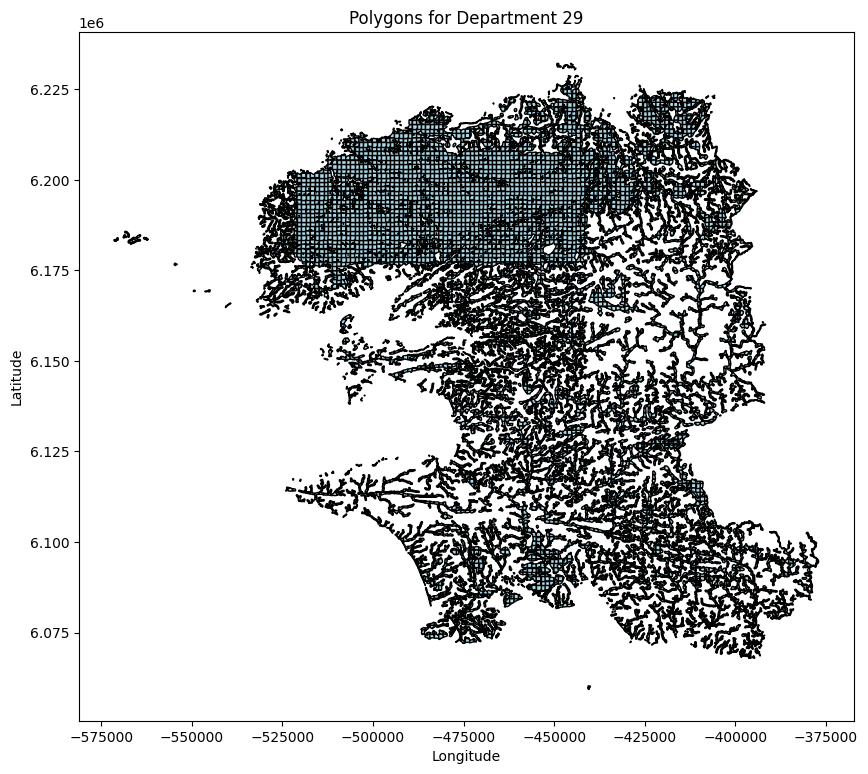

In [ ]:
# Filter and plot the data for department 29
fig, ax = plt.subplots(figsize=(10, 10))
argile_gdf[argile_gdf['DPT'] == '29'].plot(ax=ax, color='lightblue', edgecolor='black')
ax.set_title("Polygons for Department 29")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

In [ ]:
# Liste des codes INSEE des départements de la région PACA
paca_departments = ['04', '05', '06', '13', '83', '84']

#argile_gdf[argile_gdf['DPT'].isin(paca_departments)].explore()
